<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Predicting Weather from RDU's Weather Station Using an Ensemble

## Background

For our non-linear model we opted for an ensemble model of three non-linear regressors, which together generate an overall non-linear final prediction.
The models we selected are:
- **Random Forest Regressor (RF)**
- **Gradient Boosting Regressor (GB)**
- **Support Vector Regressor (SVR)**

The ensemble was implemented using a **Voting Regressor**, which averages the predictions from each model (no variable weighting).
By creating an ensemble, we hoped to balance the differing strengths and weaknesses of each model to improve generalization.


## Data
The input dataset for this model consists of hourly weather data gathered and cleaned through the Meteostat API (see Lindsay’s Data Acquisition section).
Each row represents a single hour, containing features such as:
- Temperature
- Precipitation (prcp)
- Wind direction (wdir)
- Wind speed
- Humidity

The dataset covers the period **2015-2025** and has been cleaned for missing values, outliers, and inconsistent formatting.
All datetime fields were standardized and sorted chronologically to prevent data leakage.

---

## Approach

### Model Overview
Each component model contributes a unique bias-variance profile:

- **Random Forest Regressor (RF)**
  Creates an ensemble of 200 bootstrapped decision trees.
  Each tree trains on a subset of features and data points, promoting generalization and lowering variance through averaging.
  This method produces a smooth, though discrete, function that is non-linear by design.

- **Gradient Boosting Regressor (GB)**
  Builds 200 trees sequentially, where each new tree predicts the residuals (errors) of the previous iteration.
  We used a learning rate (`alpha`) of **0.05** to control step size and prevent overfitting.
  This model typically has higher variance and lower bias than RF.

- **Support Vector Regressor (SVR)**
  Fits a smooth, continuous function through the data, using a **radial basis function (RBF) kernel** to model complex, high-dimensional relationships.
  SVR introduces non-linearity by mapping inputs into a feature space without explicitly defining its dimensions.

---

### Ensemble Construction
We combined the three models using a **Voting Regressor** to produce an averaged prediction across the outputs of RF, GB, and SVR.


In [1]:
import os
import numpy as np
import pandas as pd

from src.create_combined import load_and_clean_weather

df = load_and_clean_weather()

Reading 72306-2015.csv ...
Reading 72306-2016.csv ...
Reading 72306-2017.csv ...
Reading 72306-2018.csv ...
Reading 72306-2019.csv ...
Reading 72306-2020.csv ...
Reading 72306-2021.csv ...
Reading 72306-2022.csv ...
Reading 72306-2023.csv ...
Reading 72306-2024.csv ...
Reading 72306-2025.csv ...
Final dataset: 94599 rows, 10 columns
Date range: 2015-01-01 00:00:00 → 2025-10-16 15:00:00


## Data Usage

From Lindsay's notebook I created a series of functions in `data_clean.py` that implements her work and saves the data to `Data_Cleaned_Final`

This cell only needs to be run once and if the original files are all saved it does not need to be downloaded at all.

In [2]:
from src.data_clean import clean_data

output = clean_data(df) ## Using Modification's of Lindsay's Function in src.data_clean

os.makedirs("Data_Cleaned", exist_ok=True)
output.to_csv("Data_Cleaned/cleaned_weather_final.csv", index=False)

Reading 72306-2015.csv ...
Reading 72306-2016.csv ...
Reading 72306-2017.csv ...
Reading 72306-2018.csv ...
Reading 72306-2019.csv ...
Reading 72306-2020.csv ...
Reading 72306-2021.csv ...
Reading 72306-2022.csv ...
Reading 72306-2023.csv ...
Reading 72306-2024.csv ...
Reading 72306-2025.csv ...

Combined dataset shape: 94599 rows, 22 columns.
Columns found: ['year', 'month', 'day', 'hour', 'temp', 'temp_source', 'rhum', 'rhum_source', 'prcp', 'prcp_source', 'wdir', 'wdir_source', 'wspd', 'wspd_source', 'wpgt', 'wpgt_source', 'pres', 'pres_source', 'cldc', 'cldc_source', 'coco', 'coco_source']
---- Cleaning Data ----
Datetime column built and moved to front.
Dropped 'cldc' column due to high missingness.
Interpolated '{col}': {nulls_before} → {nulls_after} missing values.
Interpolated '{col}': {nulls_before} → {nulls_after} missing values.
Cleaned dataset has {len(df)} rows and {len(df.columns)} columns.
-----------------------
Sanity check: dropped {before - after} rows with remaining

## Pipeline

The data is tested through our model pipeline. The functions are located in `src/ensemble/model_creation.py`

There are three different non-linear models that all voting on the final predictions. In terms of features, no new features were generated for generalizability across different models. However, synthetic data was used to guess the likely rhum, prcp, and wdir to for our X_test category. The method for obtaining this synthetic data was to assume an average from the past 10 years for each hour. While a linear regression could have also sufficed, looking at the data did not show a clear pattern for each time series.

Additionally, joblib was used to save the model in case we need to rerun it with the X_test for when the pandas frames do not have the same number of spaces without needing to spend another 28 minutes running the models.

Fitting ensemble...


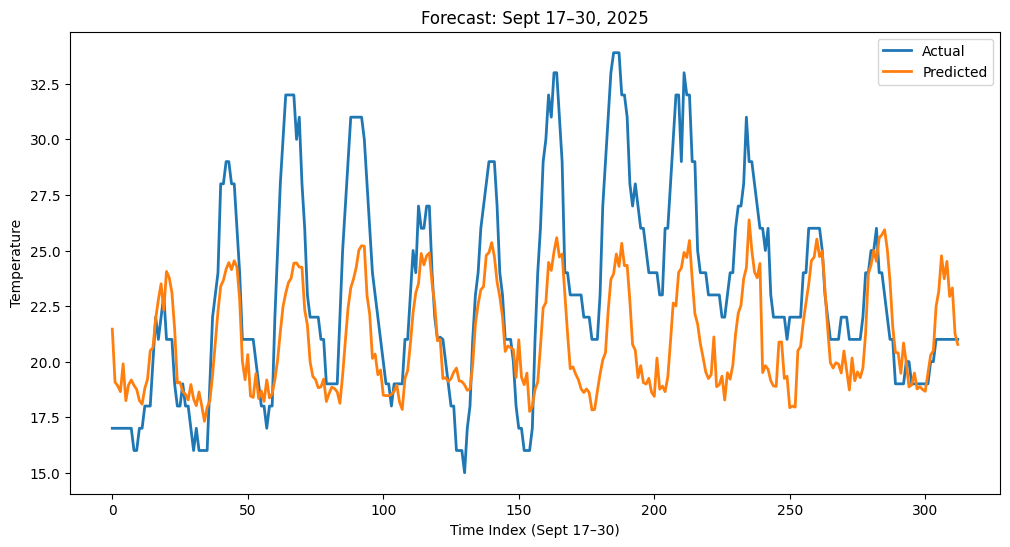

In [3]:
import matplotlib.pyplot as plt
from src.ensemble.model_creation import run_pipeline

X_train, y_train, X_test, y_test, model, y_pred = run_pipeline(
    weather_filename="Data_Cleaned/cleaned_weather_final.csv",
    forecast_start="2025-09-17",
    forecast_end="2025-09-30"
)

# Initial Figure
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(y_pred, label="Predicted", linewidth=2)
plt.title("Forecast: Sept 17–30, 2025")
plt.xlabel("Time Index (Sept 17–30)")
plt.ylabel("Temperature")
plt.legend()
plt.show()


## Model Evaluation

This cell can be run on it's own to generate data eval. Initial logic sees if the model is currently saved to system memory. If so it saves the forecast to the location. If no variable named model exists it will assume the forecast is saved as `1forecast_sept2025.csv` and then run our model evaluation.

In [4]:
import os
import pandas as pd
from src.evaluate_predictions import evaluate_preds

os.makedirs("Nonlinear_Forecast_Final", exist_ok=True)
file_path = "Nonlinear_Forecast_Final/1forecast_sept2025.csv"

# If a model exists, save new predictions
if "model" in locals() and model is not None:
    pred_df = pd.DataFrame({
        "actual": y_test.values,
        "predicted": y_pred
    })

    # Add datetime if available
    if hasattr(y_test, "index"):
        pred_df.insert(0, "datetime", y_test.index)

    pred_df.to_csv(file_path, index=False)
    print("Saved new forecast data to", file_path)

# Otherwise, load the last saved forecast
else:
    pred_df = pd.read_csv(file_path)
    print("Loaded existing forecast data from", file_path)

# Extract columns for evaluation
y_test = pred_df["actual"]
y_pred = pred_df["predicted"]

# Use datetime if available
time_index = pred_df["datetime"] if "datetime" in pred_df.columns else None

# Run evaluation
evaluate_preds(y_test, y_pred)

Saved new forecast data to Nonlinear_Forecast_Final/1forecast_sept2025.csv
Evaluation Results:
  MSE: 14.815
  RMSE: 3.849
  MAE: 3.047
  R2: 0.264


{'MSE': 14.815152208640413,
 'RMSE': np.float64(3.849045623091575),
 'MAE': 3.046533158731706,
 'R2': 0.26375470172209137}

## Graph Generation and Further Statistics

This cell is ran to generate our graphs and make them more interpretable. Notably, because we started getting data in January 2015, our September 17, 2025 data starts at column 93886, hence the orphan variable, that I attempted to comment. All of these functions are located in `src/residuals.py`

Model Evaluation
Residual Summary
Mean Residual: 2.147780611324646
Median Residual: 1.761595894992329
Residual Std Dev: 3.19920146025198
Mean Absolute Error: 3.046533158731706
Skewness: 0.2566499911520013
Kurtosis: -0.6301503047977794


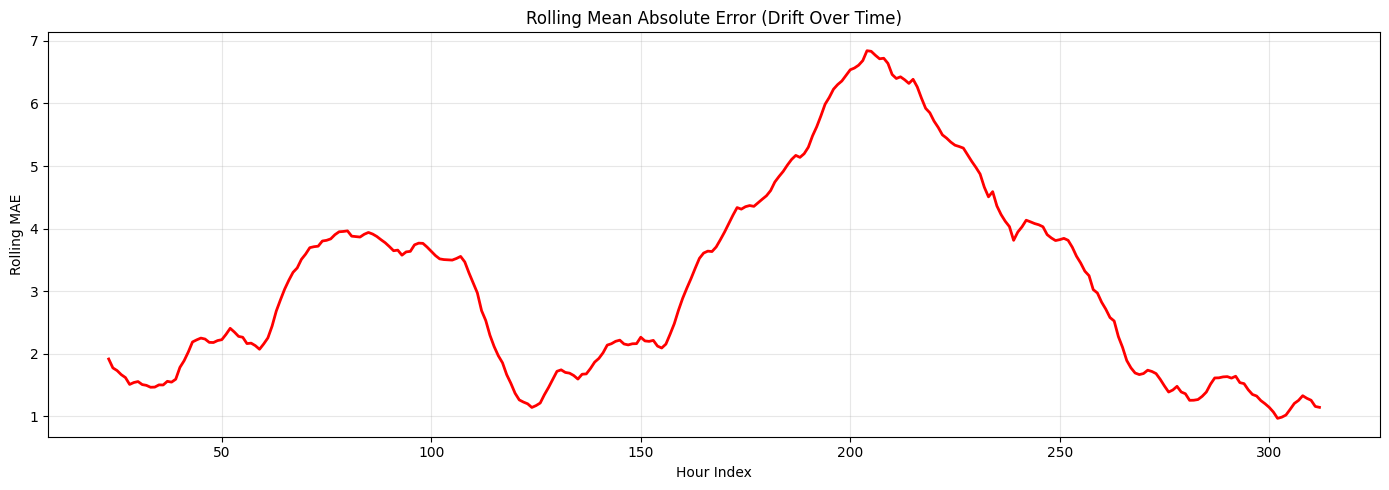

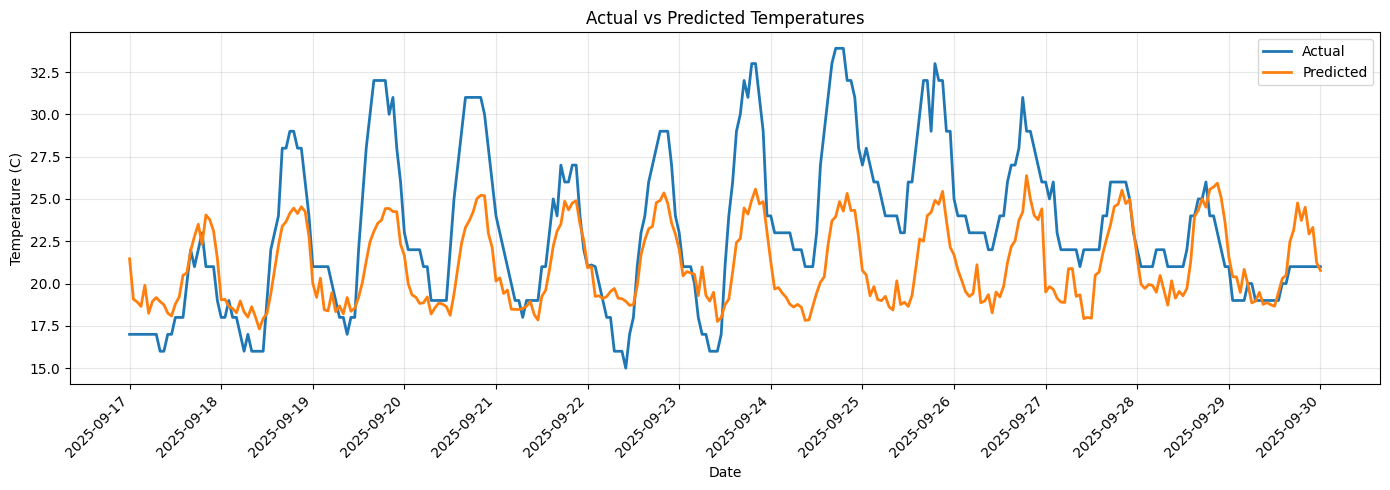

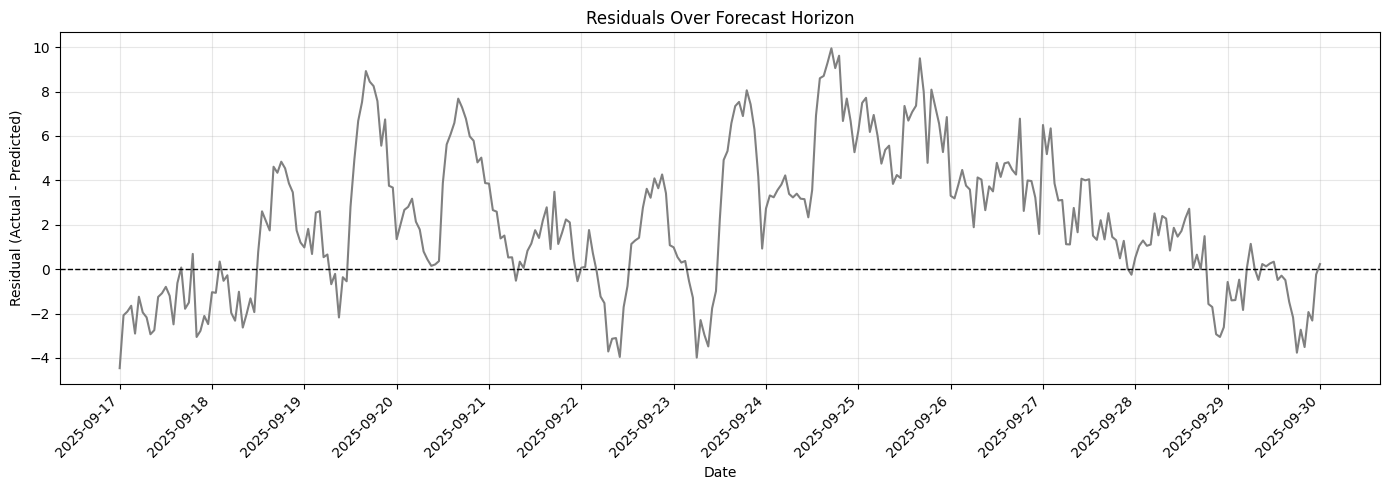

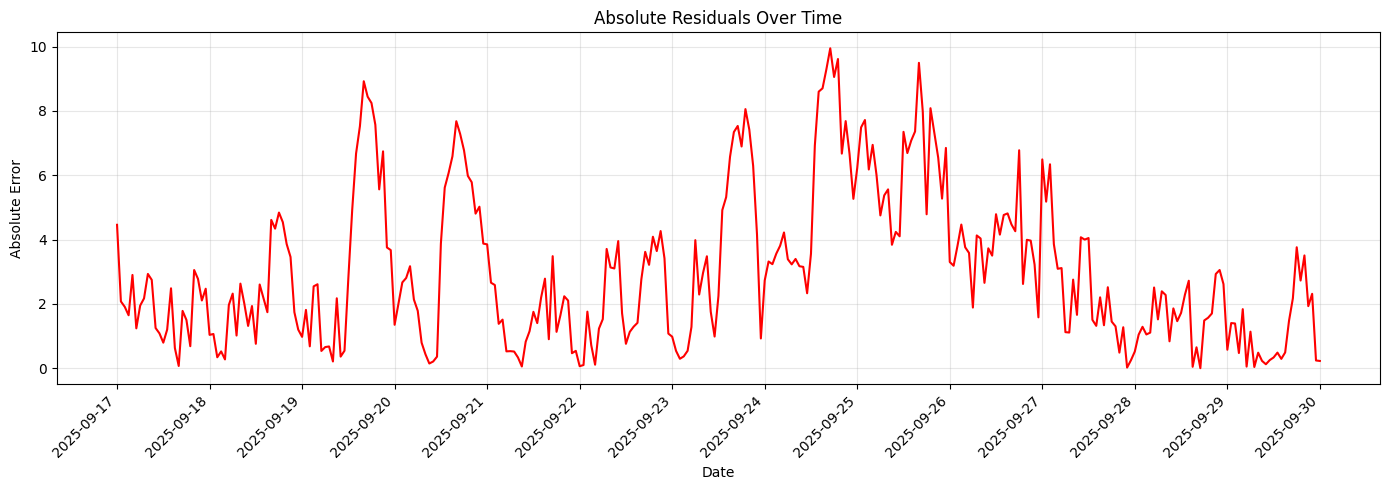

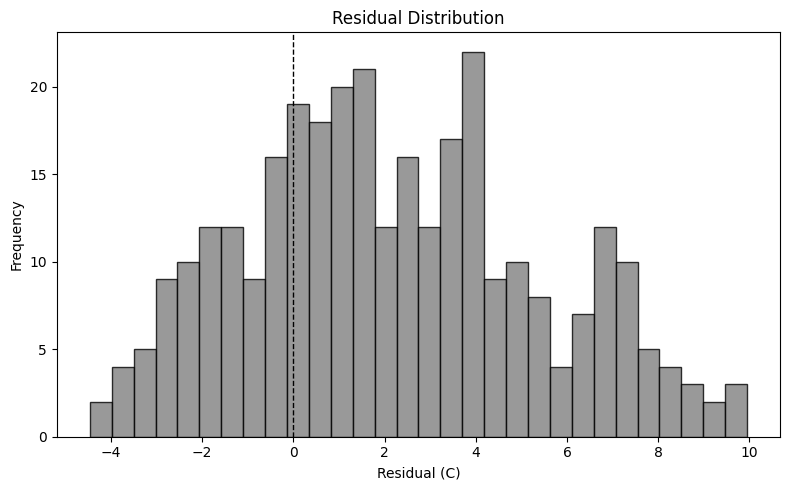

In [5]:
import pandas as pd
import importlib
import src.residuals
importlib.reload(src.residuals)
from src.residuals import model_eval, graph_making

df = pd.read_csv("Nonlinear_Forecast_Final/1forecast_sept2025.csv")

time_index = df["datetime"] - 93886
## This corresponds when we initially selected the data starting in 2015 but we can just start at a new 0.
y_test = df["actual"]
y_pred = df["predicted"]

# Evaluate and plot
residuals = model_eval(y_test, y_pred, time_index)
graph_making(y_test, y_pred, time_index)


### Saved for Reference

This data is generated previously but pasted here in case notebook refreshes.

MSE: 14.815
  RMSE: 3.849
  MAE: 3.047
  R2: 0.264
  R2: 0.424

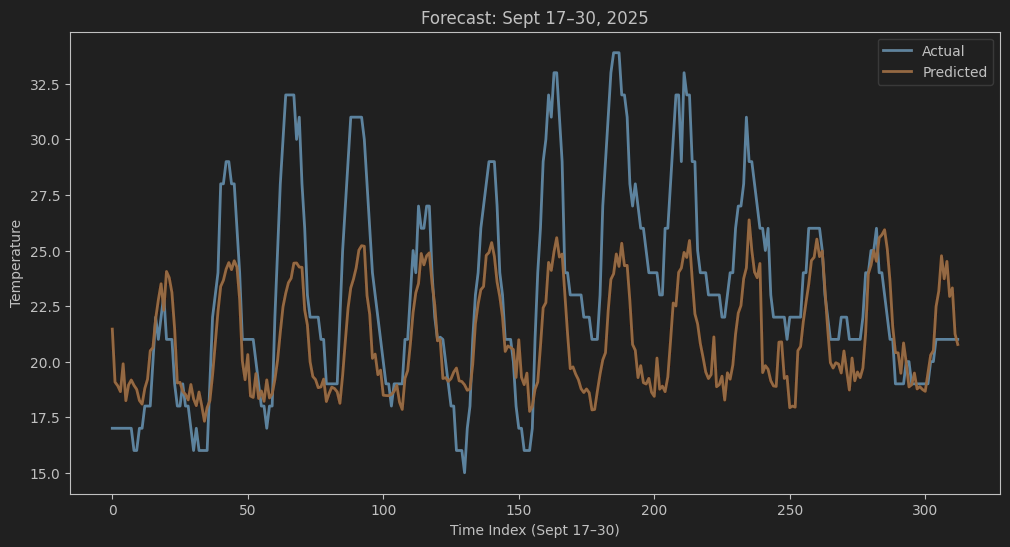

Model Evaluation
Residual Summary
Mean Residual: 2.147780611324646
Median Residual: 1.761595894992329
Residual Std Dev: 3.19920146025198
Mean Absolute Error: 3.046533158731706
Skewness: 0.2566499911520013
Kurtosis: -0.6301503047977794

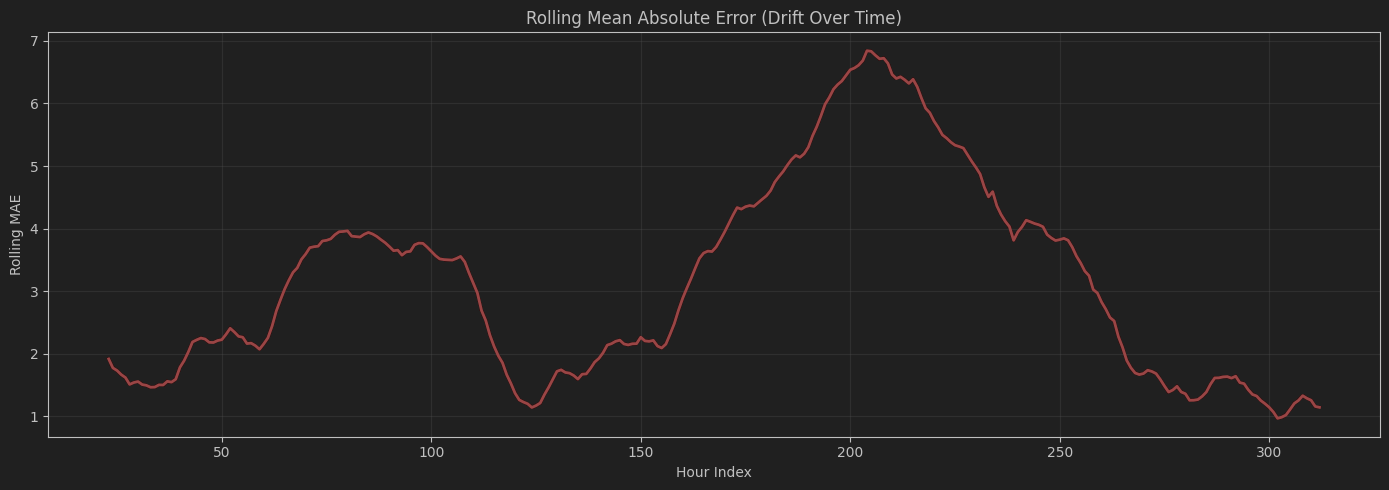

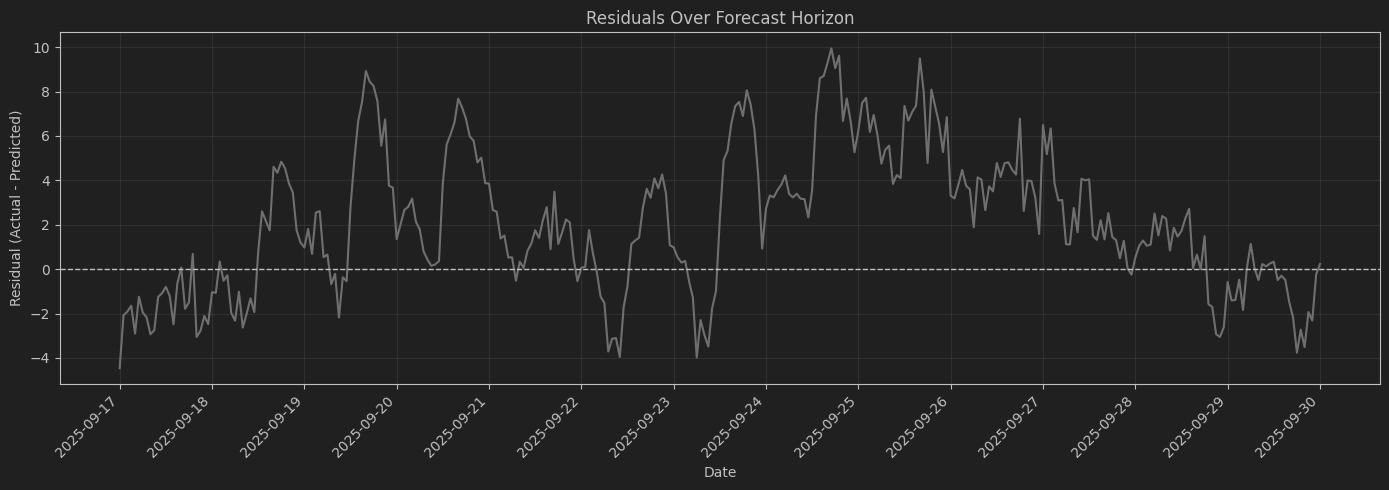

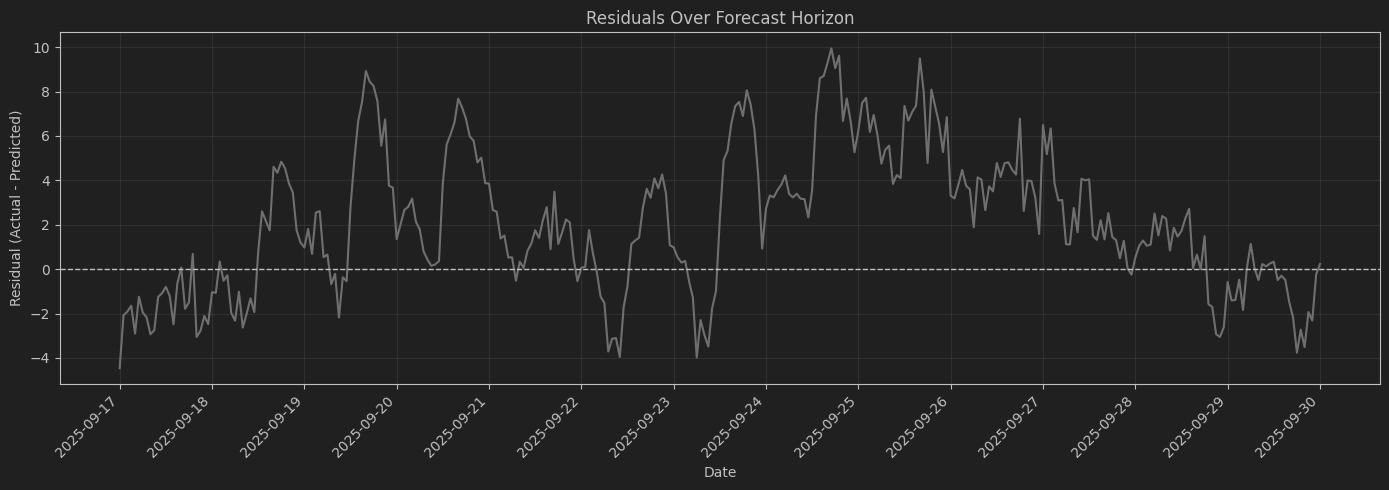

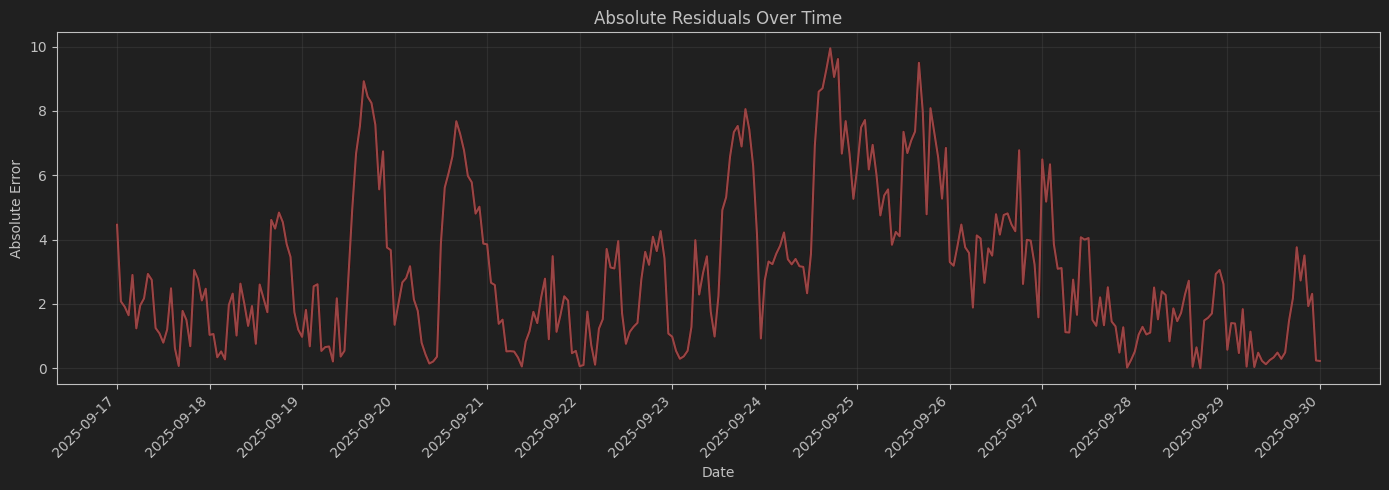

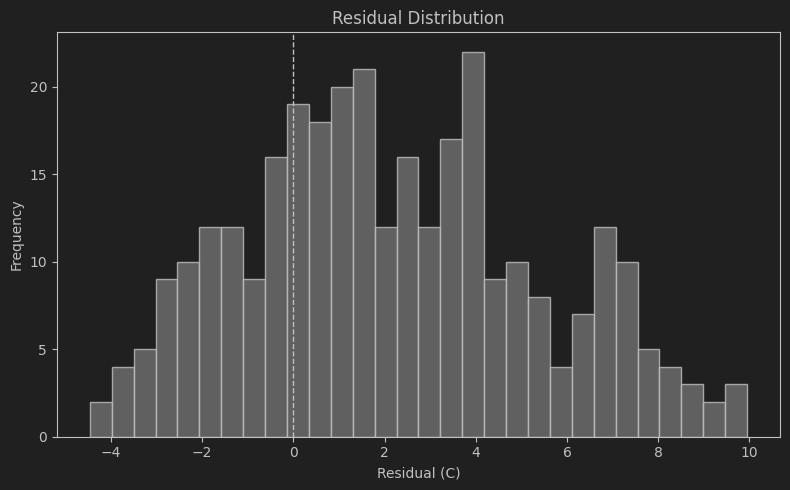

Old:

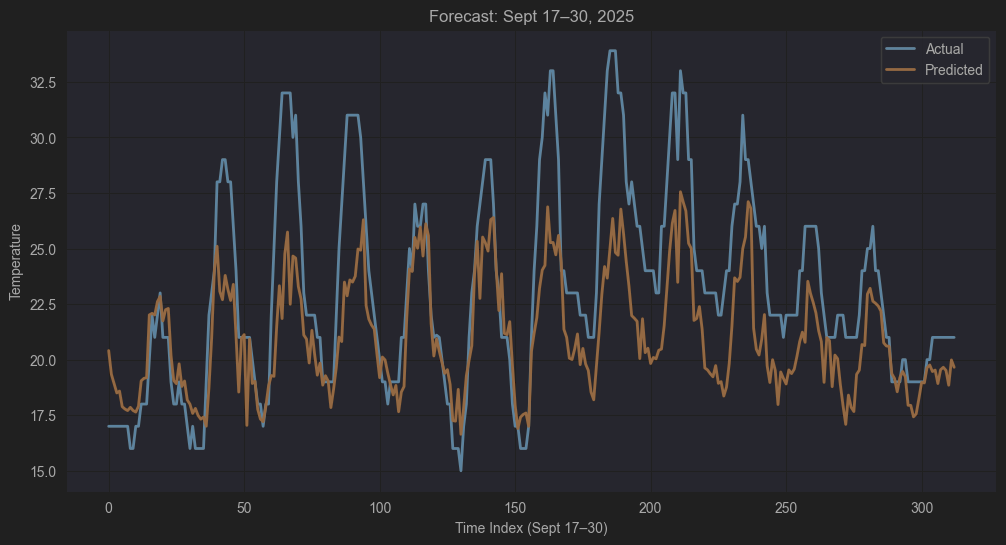